In [1]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
from models.scripts.utils import preprocess, trigonometric_date_encoding

file_paths = ['../data/hourly/ada_lunarcrush_timeseries_hourly.csv', '../data/hourly/btc_lunarcrush_timeseries_hourly.csv', '../data/hourly/doge_lunarcrush_timeseries_hourly.csv', '../data/hourly/eth_lunarcrush_timeseries_hourly.csv', '../data/hourly/xmr_lunarcrush_timeseries_hourly.csv', '../data/hourly/xrp_lunarcrush_timeseries_hourly.csv', '../data/hourly/aave_lunarcrash_timeseries_hourly.csv']

columns_to_keep = ['timestamp', 'time', 'open', 'close', 'high', 'low', 'volume_24h', 'market_cap', 'social_contributors', 'social_volume', 'tweets', 'day', 'month', 'year', 'Month_Category_Bearish', 'Month_Category_Bullish', 'Month_Category_Normal', 'ROC_0', 'ROC_1', 'ROC_2']

crypto_dfs = {}
for path in file_paths:
    crypto = os.path.basename(path).split('_')[0]
    if os.path.exists(path):  # Check if the file exists
        crypto_dfs[crypto] = preprocess(path)
        crypto_dfs[crypto] = crypto_dfs[crypto][[col for col in crypto_dfs[crypto].columns if col in columns_to_keep]]
    else:
        print(f"File does not exist: {path}")  # For debugging

# Model Training on Sentiment-enhanced data

## LSTM

In [4]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_simple_LSTM_regressor(input_shape, output_units=1):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # LSTM layer
    lstm = tfkl.LSTM(64, activation='leaky_relu', return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(64, activation='leaky_relu')(lstm)

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(lstm)  # Single unit for regression output

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='Simple_LSTM_regressor')

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Return the model
    return model

In [5]:
def fit(X_train, y_train, X_val, y_val):

    # Assuming input_shape is (5, n_features)
    input_shape = (X_train.shape[1], X_train.shape[2])
    output_units = 1

    # Build and compile the model
    model = build_simple_LSTM_regressor(input_shape, output_units)
    model.summary()

    # Train the model
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=64,
        validation_data=(X_val, y_val),
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history

    return model, history

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate(model, X_test, y_test):

    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mse, mae, mape

In [7]:
from models.scripts.utils import split_data_frame, apply_functions

def run_model_for_dataframe(df):
    # Split the DataFrame into train, validation, and test sets
    train, val, test = split_data_frame(df, 0.7, 0.2)

    # Apply any additional functions to preprocess the data
    X_train, y_train, X_val, y_val, X_test, y_test = apply_functions(train, test, val)

    # Fit the model
    model, history = fit(X_train, y_train, X_val, y_val)

    # Get the evaluation metrics for each set
    mse, mae, mape = evaluate(model, X_test, y_test)

    # Return the evaluation metrics along with the model and history
    return model, history, (mse, mae, mape)

# Assuming crypto_dfs is your dictionary of DataFrames for each crypto
summary_table = []

for crypto, df in crypto_dfs.items():
    print(f"Running model for {crypto}...")
    model, history, metrics = run_model_for_dataframe(df)

    # Unpack the metrics
    lstm = 'LSTM_sentiment'
    mse, mae, mape = metrics

    # Append the metrics to the summary table
    summary_table.append({
        'Data': crypto,
        'Model': lstm,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape
    })

# Convert the summary table to a DataFrame
lstm_df = pd.DataFrame(summary_table)
lstm_df.to_csv('../results/lstm_sentiment.csv')
lstm_df

Running model for ada...
Model: "Simple_LSTM_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 22)]           0         
                                                                 
 lstm (LSTM)                 (None, 5, 64)             22272     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 55361 (216.25 KB)
Trainable params: 55361 (216.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
423/423 [==============================] - 2s 5ms/step - loss: 0.0240 - mae: 0.0581 - val_loss: 0.0021

,Data,Model,MSE,MAE,MAPE
0,ada,LSTM_sentiment,0.003298,0.050398,0.196977
1,btc,LSTM_sentiment,0.000486,0.015871,0.171378
2,doge,LSTM_sentiment,0.000255,0.013051,1.090816
3,eth,LSTM_sentiment,0.001343,0.034302,0.852801
4,xmr,LSTM_sentiment,0.000239,0.012693,0.307682
5,xrp,LSTM_sentiment,0.001102,0.022688,0.899633
6,aave,LSTM_sentiment,0.239753,0.470003,0.671878


## LSTM-CNN

In [8]:
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_improved_LSTM_CNN(input_shape, output_units):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # CNN Layer 1
    cnn = tfkl.Conv1D(256, 3, padding='same')(input_layer)  # Increased number of filters and adjusted kernel size
    cnn = tfkl.LeakyReLU(alpha=0.2)(cnn)
    cnn = tfkl.MaxPooling1D(pool_size=2)(cnn)  # Added pool_size

    # CNN Layer 2
    cnn = tfkl.Conv1D(128, 3, padding='same')(cnn)  # Adjusted number of filters and kernel size
    cnn = tfkl.LeakyReLU(alpha=0.2)(cnn)
    cnn = tfkl.MaxPooling1D(pool_size=2)(cnn)  # Added pool_size

    # LSTM Layer 1
    lstm = tfkl.LSTM(128, return_sequences=True)(cnn)  # Increased the number of units
    lstm = tfkl.Dropout(0.2)(lstm)  # Added dropout for regularization

    # LSTM Layer 2
    lstm = tfkl.LSTM(128)(lstm)  # Adjusted the number of units
    lstm = tfkl.Dropout(0.2)(lstm)  # Added dropout for regularization

    # Feature Extractor Layer
    dense = tfkl.Dense(64)(lstm)  # Adjusted the number of units
    dense = tfkl.LeakyReLU(alpha=0.2)(dense)
    dense = tfkl.Dropout(0.2)(dense)  # Added dropout for regularization

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(dense)  # No activation for regression output

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='Improved_LSTM_CNN')

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    return model

In [9]:
def fit(X_train, y_train, X_val, y_val):

    input_shape = (X_train.shape[1], X_train.shape[2])
    output_units = 1  # Assuming we want to predict one feature, e.g., close price for one day ahead

    # Build and compile the model
    model = build_improved_LSTM_CNN(input_shape, output_units)
    model.summary()

    # Train the model
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=32,
        validation_data=(X_val, y_val),
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history

    return model, history

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate(model, X_test, y_test):

    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mse, mae, mape

In [11]:
from models.scripts.utils import split_data_frame, apply_functions

def run_model_for_dataframe(df):
    # Split the DataFrame into train, validation, and test sets
    train, val, test = split_data_frame(df, 0.7, 0.2)

    # Apply any additional functions to preprocess the data
    X_train, y_train, X_val, y_val, X_test, y_test = apply_functions(train, test, val)

    # Fit the model
    model, history = fit(X_train, y_train, X_val, y_val)

    # Get the evaluation metrics for each set
    mse, mae, mape = evaluate(model, X_test, y_test)

    # Return the evaluation metrics along with the model and history
    return model, history, (mse, mae, mape)

# Assuming crypto_dfs is your dictionary of DataFrames for each crypto
summary_table = []

for crypto, df in crypto_dfs.items():
    print(f"Running model for {crypto}...")
    model, history, metrics = run_model_for_dataframe(df)

    # Unpack the metrics
    lstm_cnn = 'LSTM-CNN_sentiment'
    mse, mae, mape = metrics

    # Append the metrics to the summary table
    summary_table.append({
        'Data': crypto,
        'Model': lstm_cnn,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape
    })

# Convert the summary table to a DataFrame
lstm_cnn_df = pd.DataFrame(summary_table)
lstm_cnn_df.to_csv('../results/lstm_cnn_sentiment.csv')
lstm_cnn_df

Running model for ada...
Model: "Improved_LSTM_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 22)]           0         
                                                                 
 conv1d (Conv1D)             (None, 5, 256)            17152     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 256)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 256)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            98432     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 2, 128)            0         
                        

,Data,Model,MSE,MAE,MAPE
0,ada,LSTM-CNN,0.020265,0.121398,0.277190
1,btc,LSTM-CNN,0.007930,0.072749,1.834286
2,doge,LSTM-CNN,0.004268,0.056103,5.584329
3,eth,LSTM-CNN,0.005444,0.066412,1.303854
4,xmr,LSTM-CNN,0.041189,0.186515,7.039220
5,xrp,LSTM-CNN,0.012900,0.102465,3.374718
6,aave,LSTM-CNN,0.067126,0.219814,0.334660


## TRANSFORMER

In [18]:
from keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
    """
    Creates a single transformer block.
    """
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

def build_transformer(n_timesteps, n_features, head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
    """
    Creates a transformer model by building multiple transformer blocks.
    """
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

In [20]:
import time

def fit_transformer(X_train, y_train, X_val, y_val):
    """
    Compiles and fits our transformer with the provided training and validation data.
    """
    transformer = build_transformer(n_timesteps=X_train.shape[1], n_features=X_train.shape[2], head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)    
    
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
        metrics=["mae", "mape"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]

    start = time.time()
    history = transformer.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=64,
        epochs=100,
        verbose=1,
        callbacks=callbacks
    ).history

    print(f"Training completed in {time.time() - start:.2f} seconds")
    return transformer, history

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate(model, X_test, y_test):

    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mse, mae, mape

In [24]:
def run_transformer_for_dataframe(df):

    # Preprocessing steps
    train, val, test = split_data_frame(df, 0.7, 0.2)
    X_train, y_train, X_val, y_val, X_test, y_test = apply_functions(train, test, val)

    transformer, history = fit_transformer(X_train, y_train, X_val, y_val)

    # Evaluate the model
    mse, mae, mape = evaluate(transformer, X_test, y_test)

    # Return the model, history, and metrics
    return transformer, history, (mse, mae, mape)

In [25]:
summary_table = []

for crypto, df in crypto_dfs.items():

    print(f"Running model for {crypto}...")
    model, history, metrics = run_transformer_for_dataframe(df)

    # Unpack the metrics
    transformer_sent = 'Transformer_sentiment'
    mse, mae, mape = metrics

    # Append the metrics to the summary table
    summary_table.append({
        'Data': crypto,
        'Model': transformer_sent,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape
    })

# Convert the summary table to a DataFrame
transformer_sent_df = pd.DataFrame(summary_table)
transformer_sent_df.to_csv('../results/transformer_sentiment.csv')
transformer_sent_df

Running model for ada...
Epoch 1/100
423/423 [==============================] - 10s 21ms/step - loss: 0.0245 - mae: 0.0861 - mape: 16.5231 - val_loss: 0.0071 - val_mae: 0.0776 - val_mape: 15.1800 - lr: 0.0010
Epoch 2/100
423/423 [==============================] - 9s 22ms/step - loss: 0.0045 - mae: 0.0484 - mape: 9.2058 - val_loss: 0.0032 - val_mae: 0.0515 - val_mape: 10.0207 - lr: 0.0010
Epoch 3/100
423/423 [==============================] - 8s 19ms/step - loss: 0.0032 - mae: 0.0410 - mape: 7.2988 - val_loss: 0.0017 - val_mae: 0.0373 - val_mape: 7.2027 - lr: 0.0010
Epoch 4/100
423/423 [==============================] - 9s 20ms/step - loss: 0.0026 - mae: 0.0367 - mape: 7.0521 - val_loss: 0.0023 - val_mae: 0.0446 - val_mape: 8.7783 - lr: 0.0010
Epoch 5/100
423/423 [==============================] - 9s 20ms/step - loss: 0.0024 - mae: 0.0344 - mape: 5.9234 - val_loss: 7.9760e-04 - val_mae: 0.0252 - val_mape: 5.0647 - lr: 0.0010
Epoch 6/100
423/423 [==============================] - 8s 20ms

,Data,Model,MSE,MAE,MAPE
0,ada,Transformer_sentiment,0.000090,0.005927,0.028767
1,btc,Transformer_sentiment,0.001656,0.013554,0.154099
2,doge,Transformer_sentiment,0.000071,0.005782,0.378267
3,eth,Transformer_sentiment,0.000155,0.008440,0.327412
4,xmr,Transformer_sentiment,0.000166,0.009335,0.370243
5,xrp,Transformer_sentiment,0.000342,0.013617,0.510229
6,aave,Transformer_sentiment,0.248934,0.483078,0.693312


### Results

In [27]:
models = ['LSTM', 'LSTM-CNN', 'Transformer', 'LSTM_sentiment', 'LSTM-CNN_sentiment', 'Transformer_sentiment']
cryptos = ['ada', 'btc', 'doge', 'eth', 'xmr', 'xrp', 'aave']
file_paths = ['../results/lstm.csv', '../results/lstm_cnn.csv', '../results/transformer.csv', '../results/lstm_sentiment.csv', '../results/lstm_cnn_sentiment.csv', '../results/transformer_sentiment.csv']

results = pd.DataFrame(index=models, columns=cryptos)

# Loop through each file and each crypto to fill the DataFrame
for model, file_path in zip(models, file_paths):
    df = pd.read_csv(file_path)
    for crypto in cryptos:
        results.at[model, crypto] = df.loc[df['Data'] == crypto, 'MAE'].values[0]

results

,ada,btc,doge,eth,xmr,xrp,aave
LSTM,0.039191,0.036518,0.04523,0.058626,0.034918,0.0142,0.402494
LSTM-CNN,0.081877,0.042862,0.050316,0.039123,0.046871,0.026126,0.44255
Transformer,0.581803,0.0107,0.026137,0.608224,0.012544,0.173767,0.093047
LSTM_sentiment,0.050398,0.015871,0.013051,0.034302,0.012693,0.022688,0.470003
LSTM-CNN_sentiment,0.121398,0.072749,0.056103,0.066412,0.186515,0.102465,0.219814
Transformer_sentiment,0.005927,0.013554,0.005782,0.00844,0.009335,0.013617,0.483078


### Transfer Learning

Testing if training on ETH to predict BTC works

In [57]:
btc = crypto_dfs['btc']
eth = crypto_dfs['eth']

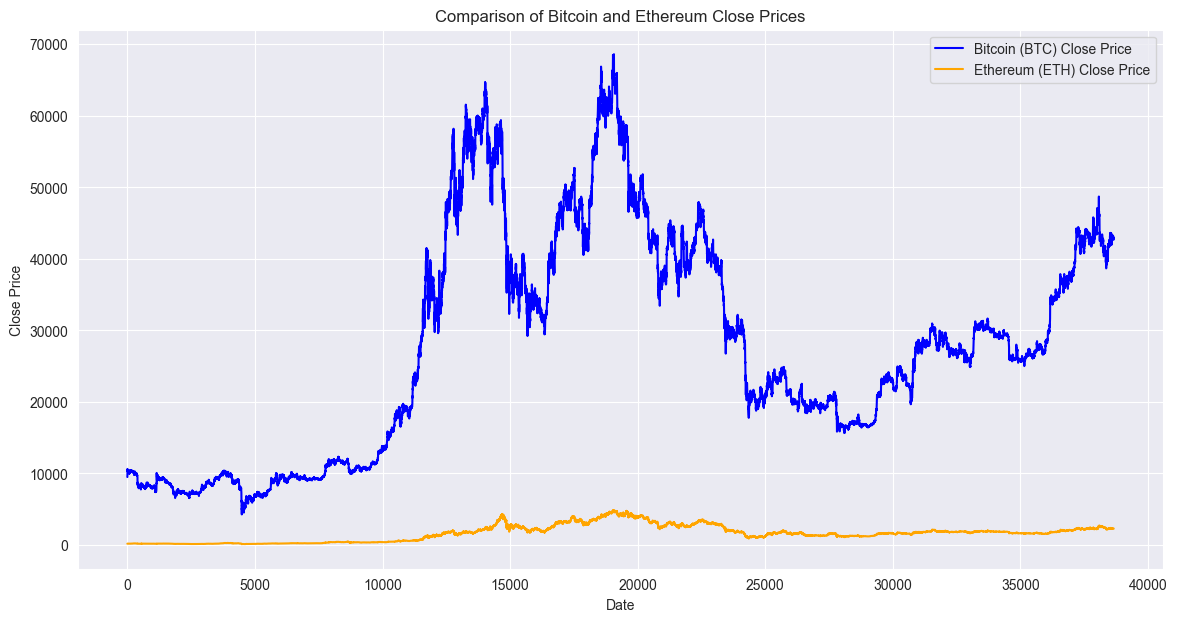

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))  # Set the figure size for better readability
plt.plot(btc['close'], label='Bitcoin (BTC) Close Price', color='blue')  # Plot Bitcoin close prices
plt.plot(eth['close'], label='Ethereum (ETH) Close Price', color='orange')  # Plot Ethereum close prices

plt.title('Comparison of Bitcoin and Ethereum Close Prices')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Close Price')  # Y-axis label
plt.legend()  # Add a legend to specify which line represents which dataset
plt.grid(True)  # Add grid lines for better readability of the plot

plt.show()  # Display the plot

In [59]:
btc_train, btc_val, btc_test = split_data_frame(btc, train_frac=0.7, val_frac=0.2)
eth_train, eth_val, eth_test = split_data_frame(eth, train_frac=0.7, val_frac=0.2)

In [61]:
X_train, y_train, X_val, y_val, X_test, y_test = apply_functions(btc_train, btc_val, eth_test)

In [63]:
tl_transformer, tl_history = fit_transformer(X_train, y_train, X_val, y_val)

Epoch 1/100
423/423 [==============================] - 9s 18ms/step - loss: 0.0164 - mae: 0.0810 - mape: 24.4477 - val_loss: 0.2502 - val_mae: 0.4980 - val_mape: 34.6677 - lr: 0.0010
Epoch 2/100
423/423 [==============================] - 8s 19ms/step - loss: 0.0046 - mae: 0.0501 - mape: 19.1252 - val_loss: 0.1360 - val_mae: 0.3632 - val_mape: 25.3010 - lr: 0.0010
Epoch 3/100
423/423 [==============================] - 8s 18ms/step - loss: 0.0030 - mae: 0.0410 - mape: 9.9953 - val_loss: 0.1235 - val_mae: 0.3483 - val_mape: 24.2590 - lr: 0.0010
Epoch 4/100
423/423 [==============================] - 8s 19ms/step - loss: 0.0025 - mae: 0.0376 - mape: 11.2940 - val_loss: 0.0863 - val_mae: 0.2890 - val_mape: 20.1357 - lr: 0.0010
Epoch 5/100
423/423 [==============================] - 8s 19ms/step - loss: 0.0024 - mae: 0.0366 - mape: 13.5782 - val_loss: 0.0901 - val_mae: 0.2966 - val_mape: 20.6609 - lr: 0.0010
Epoch 6/100
423/423 [==============================] - 8s 19ms/step - loss: 0.0022 - m

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate(model, X_test, y_test):
    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mse, mae, mape

def plot_results(model, X_test, y_test):
    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

846/846 [==============================] - 2s 3ms/step


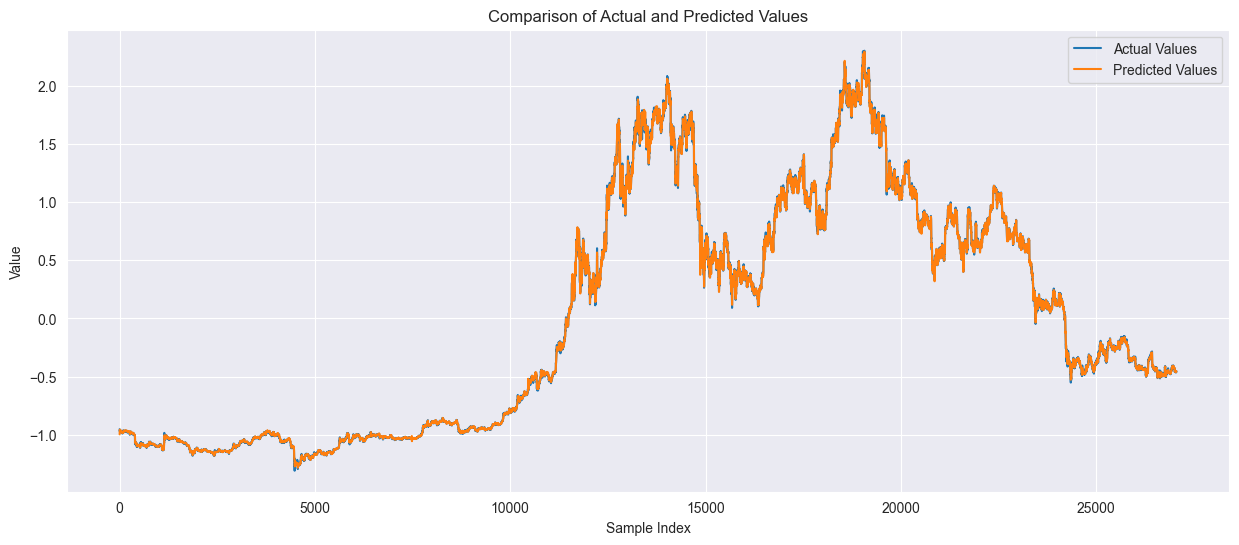

In [67]:
plot_results(tl_transformer, X_train, y_train)

121/121 [==============================] - 0s 3ms/step


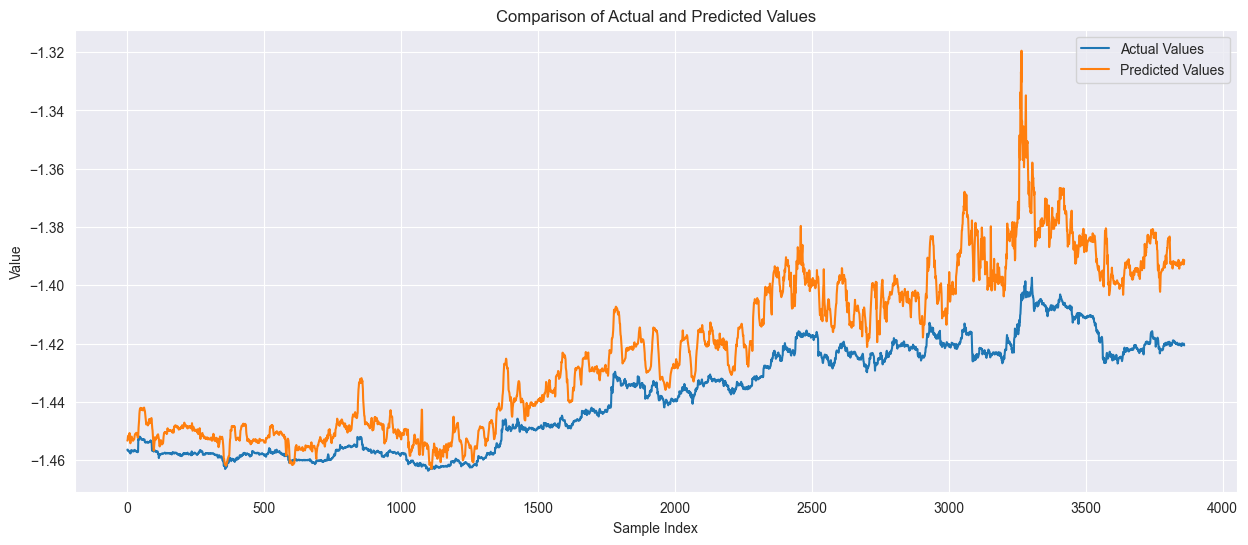

In [68]:
plot_results(tl_transformer, X_val, y_val)

242/242 [==============================] - 1s 3ms/step


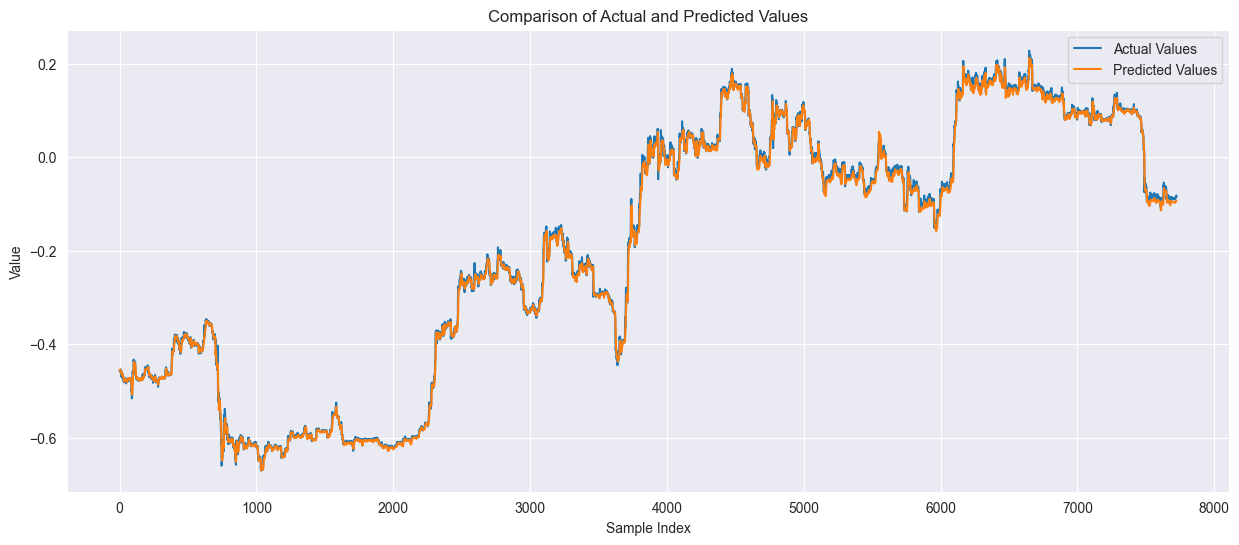

In [65]:
plot_results(tl_transformer, X_test, y_test)

In [66]:
summary = []

crypto = 'BTC-ETH'
transformer_model = 'Transformer'
mse, mae, mape = evaluate(tl_transformer, X_test, y_test)

summary.append({
    'Data': crypto,
    'Model': transformer_model,
    'MSE': mse,
    'MAE': mae,
    'MAPE': mape
})

# Convert list to DataFrame
tltr_df = pd.DataFrame(summary)
tltr_df

242/242 [==============================] - 1s 3ms/step


,Data,Model,MSE,MAE,MAPE
0,BTC-ETH,Transformer,0.000067,0.005492,0.222787
